In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import keras.datasets.cifar10 as cifar
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [2]:
def convertToOneHot(vector, num_classes=None):
    """
    Converts an input 1-D vector of integers into an output
    2-D array of one-hot vectors, where an i'th input value
    of j will set a '1' in the i'th row, j'th column of the
    output array.

    Example:
        v = np.array((1, 0, 4))
        one_hot_v = convertToOneHot(v)
        print one_hot_v

        [[0 1 0 0 0]
         [1 0 0 0 0]
         [0 0 0 0 1]]
    """

    assert isinstance(vector, np.ndarray)
    assert len(vector) > 0

    if num_classes is None:
        num_classes = np.max(vector)+1
    else:
        assert num_classes > 0
        assert num_classes >= np.max(vector)

    result = np.zeros(shape=(len(vector), num_classes))
    result[np.arange(len(vector)), vector] = 1
    
    return result.astype(int)

train : 45000 45000 (45000, 32, 32, 3) (45000,)
valid : 5000 5000 (5000, 32, 32, 3) (5000,)
test : 10000 10000 (10000, 32, 32, 3) (10000,)

frog
[0 0 0 0 0 0 1 0 0 0]


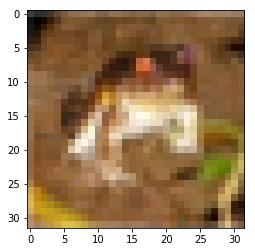

In [3]:
train, test = cifar.load_data()

train_data, train_label = train
test_data, test_label = test
train_data, valid_data = train_data[:45000], train_data[45000:]

train_label = train_label.reshape([-1])
test_label = test_label.reshape([-1])
train_label, valid_label = train_label[:45000], train_label[45000:]


dic = {}
for idx, name in enumerate(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]) :
    dic[idx] = name
    
print("train :",len(train_data), len(train_label), train_data.shape, train_label.shape)
print("valid :",len(valid_data), len(valid_label), valid_data.shape, valid_label.shape)
print("test :",len(test_data), len(test_label), test_data.shape, test_label.shape)
print("")

num = 0
plt.imshow(train_data[num])
print(dic[train_label[num]])

train_label = convertToOneHot(train_label)
valid_label = convertToOneHot(valid_label)
test_label = convertToOneHot(test_label)
print(train_label[num])

In [4]:
#데이터 차원 계산
data = tf.constant(np.array(range(32*32*3)).reshape([-1, 32, 32, 3]),dtype=tf.float32)
t1 = tf.layers.conv2d(inputs =data, filters = 16, kernel_size=[3,3], padding="SAME", strides=1, activation=tf.nn.relu)
print(t1.shape)

t2 =  tf.layers.conv2d(inputs = t1, filters=16, kernel_size=[3, 3], padding="SAME", strides=1, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
print(t2.shape)

t3 =  tf.layers.conv2d(inputs = t2, filters=32, kernel_size=[3, 3], padding="SAME", strides=2, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
print(t3.shape)

t4 =  tf.layers.conv2d(inputs = t3, filters=64, kernel_size=[3, 3], padding="SAME", strides=2, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
print(t4.shape)

t4 =  tf.layers.conv2d(inputs = t3, filters=64, kernel_size=[3, 3], padding="SAME", strides=2, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
print(t4.shape)

#Global Average Pooling
data2 =  tf.constant(np.array(range(64*64)).reshape([-1, 8, 8, 64]),dtype=tf.float32)
t5 = tf.reduce_mean(data2, [1, 2], keep_dims=True)
print(t5.shape)

sess = tf.Session()
total = 0
for idx in range(8) :
    for idx2 in range(8) :
        total += sess.run(data2[0][idx][idx2][0])

print(total/64)
print(sess.run(t5))

data3 = tf.constant(np.array(range(16*16*32)).reshape([-1,16,16,32]))
t6 = tf.layers.max_pooling2d(inputs= data3, strides=2, pool_size=[1,1])
t7 = tf.pad(t6, [[0,0], [0,0], [0,0], [16,16]])
print(t3.shape)
print(t6.shape)
print(t7.shape)

t8 = sess.run(t7)
print(t8[0][0][0][17])

sess.close()

(1, 32, 32, 16)
(1, 32, 32, 16)
(1, 16, 16, 32)
(1, 8, 8, 64)
(1, 8, 8, 64)
(1, 1, 1, 64)
2016.0
[[[[ 2016.  2017.  2018.  2019.  2020.  2021.  2022.  2023.  2024.  2025.
     2026.  2027.  2028.  2029.  2030.  2031.  2032.  2033.  2034.  2035.
     2036.  2037.  2038.  2039.  2040.  2041.  2042.  2043.  2044.  2045.
     2046.  2047.  2048.  2049.  2050.  2051.  2052.  2053.  2054.  2055.
     2056.  2057.  2058.  2059.  2060.  2061.  2062.  2063.  2064.  2065.
     2066.  2067.  2068.  2069.  2070.  2071.  2072.  2073.  2074.  2075.
     2076.  2077.  2078.  2079.]]]]
(1, 16, 16, 32)
(1, 8, 8, 32)
(1, 8, 8, 64)
1


# resNet[1]
https://arxiv.org/abs/1512.03385

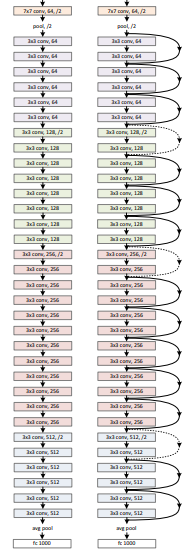

**하지만, CIFAR 데이터는 작기 때문에 논문에서 모델을 조금 변형해서 사용**

 ##  32-layers for CIFAR10

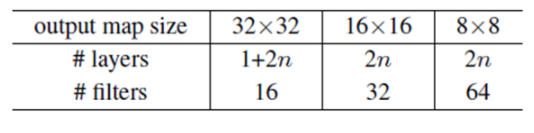

In [5]:
learning_rate = 0.005
training_epochs = 40
batch_size = 100

In [4]:
class Model1() :
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        
    def residual_block(self, X_input, num_filter, chg_dim) :
        stride = 1
        
        #stride=2일 경우
        if chg_dim :
            stride = 2
            pool1 = tf.layers.max_pooling2d(inputs= X_input, strides=2, pool_size=[1,1])
            pad1 = tf.pad(pool1, [[0,0], [0,0], [0,0], [int(num_filter/4),int(num_filter/4)]])
            shortcut = pad1
        else :
            shortcut = X_input
            
        conv1 = tf.layers.conv2d(inputs = X_input, filters=num_filter, kernel_size=[3, 3], padding="SAME", strides=stride, kernel_initializer=tf.contrib.layers.xavier_initializer())
        bm1 = tf.layers.batch_normalization(inputs = conv1)
        relu1 = tf.nn.relu(bm1)
        
        conv2 = tf.layers.conv2d(inputs = relu1, filters=num_filter, kernel_size=[3, 3], padding="SAME", strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        bm2 = tf.layers.batch_normalization(inputs = conv2)
        
        X_output = tf.nn.relu(bm2 + shortcut)
        
        return X_output

    def build(self) :
        with tf.variable_scope(self.name) :
            
            ###Input Layer
            #input : ? * 32 * 32 * 3
            #ouput : ? * 32 * 32 * 3
            self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
            self.Y = tf.placeholder(tf.float32, [None, 10])
            self.training = tf.placeholder(tf.bool)
            
            ###Hidden Layer
            #input : ? * 32 * 32 * 3
            #ouput : ? * 32 * 32 * 16
            conv = tf.layers.conv2d(inputs = self.X, filters = 16, kernel_size=[3,3], padding="SAME", strides=1)
            bm = tf.layers.batch_normalization(inputs = conv)
            relu = tf.nn.relu(bm)
            
            #input : ? * 32 * 32 * 3
            #ouput : ? * 32 * 32 * 16
            res1 = self.residual_block(relu, 16, False)
            res2 = self.residual_block(res1, 16, False)
            res3 = self.residual_block(res2, 16, False)
            res4 = self.residual_block(res3, 16, False)
            res5 = self.residual_block(res4, 16, False)

            #input : ? * 32 * 32 * 16
            #ouput : ? * 16 * 16 * 32
            res6 = self.residual_block(res5, 32, True)
            res7 = self.residual_block(res6, 32, False)
            res8 = self.residual_block(res7, 32, False)
            res9 = self.residual_block(res8, 32, False)
            res10 = self.residual_block(res9, 32, False)

            #input : ? * 16 * 16 * 32
            #ouput : ? * 8 * 8 * 64
            res11 = self.residual_block(res10, 64, True)
            res12 = self.residual_block(res11, 64, False)
            res13 = self.residual_block(res12, 64, False)
            res14 = self.residual_block(res13, 64, False)
            res15 = self.residual_block(res14, 64, False)
            
            ###Global Average Pooling
            #input : ? * 8 * 8 * 64
            #ouput : ? * 1 * 1 * 64
            gap = tf.reduce_mean(res15, [1, 2], keep_dims=True)
            
            ###Output Layer
            #input : ? * 1 * 1 * 64
            #ouput : ? * 1 * 1 * 64
            shape = gap.get_shape().as_list()
            dimension = shape[1] * shape[2] * shape[3]
            flat = tf.reshape(gap, [-1, dimension])
            
            fc = tf.layers.dense(inputs=flat, units=10, kernel_initializer=tf.contrib.layers.xavier_initializer())
            self.logits = fc

            self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.Y))
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)
            with tf.control_dependencies(update_ops):
                self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

            correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))     
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


    def predict(self, x_test, training=False):
        return self.sess.run(self.logits,feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy,feed_dict={self.X: x_test,self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.X: x_data, self.Y: y_data, self.training: training})
    
    def evaluate(self, X_input, Y_input, batch_size=None):
        N = X_input.shape[0]
            
        total_loss = 0
        total_acc = 0
            
        for i in range(0, N, batch_size):
            X_batch = X_input[i:i + batch_size]
            Y_batch = Y_input[i:i + batch_size]
                
            feed_dict = {self.X: X_batch, self.Y: Y_batch, self.training: False}
                
            loss = self.cost
            accuracy = self.accuracy
                
            step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed_dict)
                
            total_loss += step_loss * X_batch.shape[0]
            total_acc += step_acc * X_batch.shape[0]
            
        total_loss /= N
        total_acc /= N
            
        return total_loss, total_acc
                 

In [8]:
train_losses1 = []
train_accs1 = []

valid_losses1 = []
valid_accs1 = []

In [ ]:
sess = tf.Session()

model1 = Model1(sess, "model1")
model1.build()

sess.run(tf.global_variables_initializer())

print('Learning Started!')
print("")

# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(len(train_data) / batch_size)
    idx = 0

    for i in range(total_batch):
        batch_xs, batch_ys = train_data[idx:idx+batch_size], train_label[idx:idx+batch_size]
        c, _ = model1.train(batch_xs, batch_ys)
        avg_cost += c / total_batch
        idx += batch_size
        
        if i%55 == 0 :
            print("log : ", avg_cost)
            
    #train cost & acc
    cost1, acc1 = model1.evaluate(train_data, train_label, batch_size = batch_size)
    
    train_losses1.append(cost1)
    train_accs1.append(acc1)
    
    #test cost & acc
    v_cost1, v_acc1 = model1.evaluate(valid_data, valid_label, batch_size = batch_size)
    
    valid_losses1.append(v_cost1)
    valid_accs1.append(v_acc1)
    
    print("epoch : ", epoch, " -- train {:.5f}({:.1f}%), valid{:.5f}({:.1f}%)".format(cost1, acc1*100, v_cost1, v_acc1*100))
    print(" ")

print("")
print('Learning Finished!')
print('Accuracy:', model1.get_accuracy(test_data, test_label))

Learning Started!

log :  0.994857666016
log :  3.82510409498
log :  4.0777928834
log :  4.32901393509
log :  4.58039424562
log :  4.82969175005
log :  5.07561011219
log :  5.31799280214
log :  5.56048790932
log :  nan
epoch :  0  -- train 2.56089(13.5%), valid2.53956(13.4%)
 
log :  0.00504147720337


In [ ]:
tf.reset_default_graph() 

# resNet[2]

https://arxiv.org/abs/1603.05027

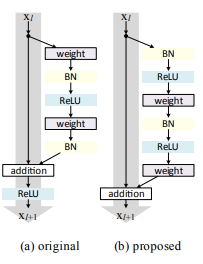

## 32-layers for CIFAR10

In [175]:
learning_rate = 0.005
training_epochs = 40
batch_size = 100

In [5]:
class Model2() :
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        
    def residual_block(self, X_input, num_filter, chg_dim) :
        stride = 1
        
        #stride=2일 경우
        if chg_dim :
            stride = 2
            pool1 = tf.layers.max_pooling2d(inputs= X_input, strides=2, pool_size=[1,1])
            pad1 = tf.pad(pool1, [[0,0], [0,0], [0,0], [int(num_filter/4),int(num_filter/4)]])
            shortcut = pad1
        else :
            shortcut = X_input
        
        bm1 = tf.layers.batch_normalization(inputs = X_input)
        relu1 = tf.nn.relu(bm1)
        conv1 = tf.layers.conv2d(inputs = relu1, filters=num_filter, kernel_size=[3, 3], padding="SAME", strides=stride, kernel_initializer=tf.contrib.layers.xavier_initializer())

        bm2 = tf.layers.batch_normalization(inputs = conv1)
        relu2 = tf.nn.relu(bm2)
        conv2 = tf.layers.conv2d(inputs = relu2, filters=num_filter, kernel_size=[3, 3], padding="SAME", strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        X_output = conv2 + shortcut
        
        return X_output

    def build(self) :
        with tf.variable_scope(self.name) :
            
            ###Input Layer
            #input : ? * 32 * 32 * 3
            #ouput : ? * 32 * 32 * 3
            self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
            self.Y = tf.placeholder(tf.float32, [None, 10])
            self.training = tf.placeholder(tf.bool)
            
            ###Hidden Layer
            #input : ? * 32 * 32 * 3
            #ouput : ? * 32 * 32 * 16
            conv = tf.layers.conv2d(inputs = self.X, filters = 16, kernel_size=[3,3], padding="SAME", strides=1)
            bm = tf.layers.batch_normalization(inputs = conv)
            relu = tf.nn.relu(bm)
            
            #input : ? * 32 * 32 * 3
            #ouput : ? * 32 * 32 * 16
            res1 = self.residual_block(relu, 16, False)
            res2 = self.residual_block(res1, 16, False)
            res3 = self.residual_block(res2, 16, False)
            res4 = self.residual_block(res3, 16, False)
            res5 = self.residual_block(res4, 16, False)

            #input : ? * 32 * 32 * 16
            #ouput : ? * 16 * 16 * 32
            res6 = self.residual_block(res5, 32, True)
            res7 = self.residual_block(res6, 32, False)
            res8 = self.residual_block(res7, 32, False)
            res9 = self.residual_block(res8, 32, False)
            res10 = self.residual_block(res9, 32, False)

            #input : ? * 16 * 16 * 32
            #ouput : ? * 8 * 8 * 64
            res11 = self.residual_block(res10, 64, True)
            res12 = self.residual_block(res11, 64, False)
            res13 = self.residual_block(res12, 64, False)
            res14 = self.residual_block(res13, 64, False)
            res15 = self.residual_block(res14, 64, False)
            
            ###Global Average Pooling
            #input : ? * 8 * 8 * 64
            #ouput : ? * 1 * 1 * 64
            gap = tf.reduce_mean(res15, [1, 2], keep_dims=True)
            
            ###Output Layer
            #input : ? * 1 * 1 * 64
            #ouput : ? * 1 * 1 * 64
            shape = gap.get_shape().as_list()
            dimension = shape[1] * shape[2] * shape[3]
            flat = tf.reshape(gap, [-1, dimension])
            
            fc = tf.layers.dense(inputs=flat, units=10, kernel_initializer=tf.contrib.layers.xavier_initializer())
            self.logits = fc

            self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.Y))
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)
            with tf.control_dependencies(update_ops):
                self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

            correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))     
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
        return self.sess.run(self.logits,feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy,feed_dict={self.X: x_test,self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.X: x_data, self.Y: y_data, self.training: training})
    
    def evaluate(self, X_input, Y_input, batch_size=None):
        N = X_input.shape[0]
            
        total_loss = 0
        total_acc = 0
            
        for i in range(0, N, batch_size):
            X_batch = X_input[i:i + batch_size]
            Y_batch = Y_input[i:i + batch_size]
                
            feed_dict = {self.X: X_batch, self.Y: Y_batch, self.training: False}
                
            loss = self.cost
            accuracy = self.accuracy
                
            step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed_dict)
                
            total_loss += step_loss * X_batch.shape[0]
            total_acc += step_acc * X_batch.shape[0]
            
        total_loss /= N
        total_acc /= N
            
        return total_loss, total_acc
                 

In [ ]:
train_losses2 = []
train_accs2 = []

valid_losses2 = []
valid_accs2 = []

In [ ]:
sess = tf.Session()

model2 = Model2(sess, "model2")
model2.build()

sess.run(tf.global_variables_initializer())

print('Learning Started!')
print("")

# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(len(train_data) / batch_size)
    idx = 0

    for i in range(total_batch):
        batch_xs, batch_ys = train_data[idx:idx+batch_size], train_label[idx:idx+batch_size]
        c, _ = model2.train(batch_xs, batch_ys)
        avg_cost += c / total_batch
        idx += batch_size
        
        if i%55 == 0 :
            print("log : ", avg_cost)

    #train cost & acc
    cost2, acc2 = model2.evaluate(train_data, train_label, batch_size = batch_size)
    
    train_losses2.append(cost2)
    train_accs2.append(acc2)
    
    #test cost & acc
    v_cost2, v_acc2 = model2.evaluate(valid_data, valid_label, batch_size = batch_size)
    
    valid_losses2.append(v_cost2)
    valid_accs2.append(v_acc2)
    
    print("epoch : ", epoch, " -- train {:.5f}({:.1f}%), valid{:.5f}({:.1f}%)".format(cost2, acc2*100, v_cost2, v_acc2*100))
    print(" ")
        

print("")
print('Learning Finished!')
print('Accuracy:', model2.get_accuracy(test_data, test_label))

In [ ]:
tf.reset_default_graph() 

# Deep CNN

## 32-layers for CIFAR10

In [ ]:
learning_rate = 0.005
training_epochs = 40
batch_size = 100

In [6]:
class Model3:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        
    def cnn_block(self, X_input, num_filter, num_iter) :
        
        for idx in range(num_iter) : 
            conv = tf.layers.conv2d(inputs=X_input, filters=num_filter, kernel_size=[3, 3],padding="SAME")
            bm = tf.layers.batch_normalization(inputs = conv)
            relu = tf.nn.relu(bm)
            X_input = relu

        return relu

    def build(self):
        with tf.variable_scope(self.name):

            self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
            self.Y = tf.placeholder(tf.float32, [None, 10])
            self.training = tf.placeholder(tf.bool)
            
            conv = tf.layers.conv2d(inputs = self.X, filters = 16, kernel_size=[3,3], padding="SAME", strides=1, activation=tf.nn.relu)
            
            cnn1 = self.cnn_block(conv, 16, 5)
            cnn2 = self.cnn_block(cnn1, 16, 4)
            pool1 = tf.layers.max_pooling2d(inputs=cnn2, pool_size=[2, 2],padding="SAME", strides=2)
            
            cnn3 = self.cnn_block(pool1, 32, 5)
            cnn4 = self.cnn_block(cnn3, 32, 4)
            pool2 = tf.layers.max_pooling2d(inputs=cnn4, pool_size=[2, 2],padding="SAME", strides=2)
            
            cnn5 = self.cnn_block(pool2, 64, 5)
            cnn6 = self.cnn_block(cnn5, 64, 4)
            pool3 = tf.layers.max_pooling2d(inputs=cnn5, pool_size=[2, 2],padding="SAME", strides=2)

            shape = pool3.get_shape().as_list()
            dimension = shape[1] * shape[2] * shape[3]

            flat = tf.reshape(pool3, [-1, dimension])
            dense = tf.layers.dense(inputs=flat,units=1000)
            bm = tf.layers.batch_normalization(inputs = dense)
            relu = tf.nn.relu(bm)

            self.logits = tf.layers.dense(inputs=relu, units=10)

            self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.Y))
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)
            with tf.control_dependencies(update_ops):
                self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

            correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
        return self.sess.run(self.logits,feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy,feed_dict={self.X: x_test,self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.X: x_data, self.Y: y_data, self.training: training})
    
    def evaluate(self, X_input, Y_input, batch_size=None):
        N = X_input.shape[0]
            
        total_loss = 0
        total_acc = 0
            
        for i in range(0, N, batch_size):
            X_batch = X_input[i:i + batch_size]
            Y_batch = Y_input[i:i + batch_size]
                
            feed_dict = {self.X: X_batch, self.Y: Y_batch, self.training: False}
                
            loss = self.cost
            accuracy = self.accuracy
                
            step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed_dict)
                
            total_loss += step_loss * X_batch.shape[0]
            total_acc += step_acc * X_batch.shape[0]
            
        total_loss /= N
        total_acc /= N
            
        return total_loss, total_acc

In [ ]:
train_losses3 = []
train_accs3 = []

valid_losses3 = []
valid_accs3 = []

In [ ]:
sess = tf.Session()

model3 = Model3(sess, "model3")
model3.build()

sess.run(tf.global_variables_initializer())

print('Learning Started!')
print("")

# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(len(train_data) / batch_size)
    idx = 0

    for i in range(total_batch):
        batch_xs, batch_ys = train_data[idx:idx+batch_size], train_label[idx:idx+batch_size]
        c, _ = model3.train(batch_xs, batch_ys)
        avg_cost += c / total_batch
        idx += batch_size
        
        if i%55 == 0 :
            print("log : ", avg_cost)

    #train cost & acc
    cost3, acc3 = model3.evaluate(train_data, train_label, batch_size = batch_size)
    
    train_losses3.append(cost3)
    train_accs3.append(acc3)
    
    #test cost & acc
    v_cost3, v_acc3 = model3.evaluate(valid_data, valid_label, batch_size = batch_size)
    
    valid_losses3.append(v_cost3)
    valid_accs3.append(v_acc3)
    
    print("epoch : ", epoch, " -- train {:.5f}({:.1f}%), valid{:.5f}({:.1f}%)".format(cost1, acc1*100, v_cost1, v_acc1*100))
    print(" ")
        

print("")
print('Learning Finished!')
print('Accuracy:', model3.get_accuracy(test_data, test_label))

In [ ]:
tf.reset_default_graph() 

# 성능 비교

In [7]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    
    res1 = [i[0] for i in loss_list]
    res2 = [i[1] for i in loss_list]
    cnn = [i[2] for i in loss_list]
    
    plt.figure(figsize=(15, 10))
    plt.plot(res1, label='original resNet')
    plt.plot(res2, label='proposed resNet')
    plt.plot(cnn, label='CNN')
    
    if ylim:
        plt.ylim(ylim)
        
    if title:
        plt.title(title)
        
    plt.legend()
    plt.grid('on')
    plt.show()

In [50]:
def plot_compare_all(loss_list1: list, loss_list2: list, ylim=None, title=None) -> None:
    
    res1_train = [i[0] for i in loss_list1]
    res2_train = [i[1] for i in loss_list1]
    cnn_train = [i[2] for i in loss_list1]
    res1_valid = [i[0] for i in loss_list2]
    res2_valid = [i[1] for i in loss_list2]
    cnn_valid = [i[2] for i in loss_list2]
    
    plt.figure(figsize=(15, 10))
    
    plt.plot(res1_train, label='original resNet_train')
    plt.plot(res2_train, label='proposed resNet_train')
    plt.plot(cnn_train, label='CNN_train')
    
    plt.plot(res1_valid, label='original resNet_valid')
    plt.plot(res2_valid, label='proposed resNet_valid')
    plt.plot(cnn_valid, label='CNN_valid')
    
    if ylim:
        plt.ylim(ylim)
        
    if title:
        plt.title(title)
        
    plt.legend()
    plt.grid('on')
    plt.show()

In [8]:
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

In [9]:
learning_rate = 0.003
training_epochs = 40
batch_size = 100

In [10]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

model1 = Model1(sess, "model1")
model1.build()

model2 = Model2(sess, "model2")
model2.build()

model3 = Model3(sess, "model3")
model3.build()

sess.run(tf.global_variables_initializer())

print('Learning Started!')
print("")

# train my model
for epoch in range(training_epochs):
    avg_cost1 = 0
    avg_cost2 = 0
    avg_cost3 = 0
    total_batch = int(len(train_data) / batch_size)
    idx = 0

    for i in range(total_batch):
        batch_xs, batch_ys = train_data[idx:idx+batch_size], train_label[idx:idx+batch_size]
        
        cost1, _ = model1.train(batch_xs, batch_ys)
        cost2, _ = model2.train(batch_xs, batch_ys)
        cost3, _ = model3.train(batch_xs, batch_ys)
        avg_cost1 += cost1 / total_batch
        avg_cost2 += cost2 / total_batch
        avg_cost3 += cost3 / total_batch
    
        idx += batch_size
        
        if i%45 == 0 :
            print("log {} : [res1, res2, cnn] = [{:.7f}, {:.7f}, {:.7f}]".format(i , avg_cost1, avg_cost2, avg_cost3))
    
    #train cost & acc
    cost1, acc1 = model1.evaluate(train_data, train_label, batch_size = batch_size)
    cost2, acc2 = model2.evaluate(train_data, train_label, batch_size = batch_size)
    cost3, acc3 = model3.evaluate(train_data, train_label, batch_size = batch_size)
    
    train_losses.append([cost1, cost2, cost3])
    train_accs.append([acc1, acc2, acc3])
    
    #test cost & acc
    v_cost1, v_acc1 = model1.evaluate(valid_data, valid_label, batch_size = batch_size)
    v_cost2, v_acc2 = model2.evaluate(valid_data, valid_label, batch_size = batch_size)
    v_cost3, v_acc3 = model3.evaluate(valid_data, valid_label, batch_size = batch_size)
    
    valid_losses.append([v_cost1, v_cost2, v_cost3])
    valid_accs.append([v_acc1, v_acc2, v_acc3])
    
    print("epoch", epoch,":", "[res1, res2, cnn] = [{:.5f}({:.2f}%), {:.5f}({:.2f}%), {:.5f}({:.2f}%)]".format(cost1, acc1*100, cost2, acc2*100, cost3, acc3*100))
    print("epoch", epoch,":", "[res1, res2, cnn] = [{:.5f}({:.2f}%), {:.5f}({:.2f}%), {:.5f}({:.2f}%)]".format(v_cost1, v_acc1*100, v_cost2, v_acc2*100, v_cost3, v_acc3*100))
    print("") 

print("")
print('Learning Finished!')

Learning Started!

log 0 : [res1, res2, cnn] = [0.9815814, 0.4631272, 0.0051167]
log 45 : [res1, res2, cnn] = [2.9525939, 3.6543798, 0.2357257]
log 90 : [res1, res2, cnn] = [3.1757332, 3.9145504, 0.4660452]
log 135 : [res1, res2, cnn] = [3.3907062, 4.1426256, 0.6963176]
log 180 : [res1, res2, cnn] = [3.6028736, 4.3589048, 0.9266025]
log 225 : [res1, res2, cnn] = [3.8064910, 4.5604633, 1.1569021]
log 270 : [res1, res2, cnn] = [4.0004034, 4.7502909, 1.3872003]
log 315 : [res1, res2, cnn] = [4.1904806, 4.9362851, 1.6174758]
log 360 : [res1, res2, cnn] = [4.3753882, 5.1251226, 1.8477933]
log 405 : [res1, res2, cnn] = [4.5566061, 5.3112783, 2.0780995]
epoch 0 : [res1, res2, cnn] = [1.81549(31.69%), 1.72602(36.46%), 2.30262(10.06%)]
epoch 0 : [res1, res2, cnn] = [1.81844(31.48%), 1.71867(36.20%), 2.30277(9.50%)]

log 0 : [res1, res2, cnn] = [0.0045693, 0.0038435, 0.0051161]
log 45 : [res1, res2, cnn] = [0.1799215, 0.1710520, 0.2354047]
log 90 : [res1, res2, cnn] = [0.3556254, 0.3411514, 0.46

log 135 : [res1, res2, cnn] = [0.3317257, 0.2913643, 0.6959634]
log 180 : [res1, res2, cnn] = [0.4457313, 0.3848130, 0.9262391]
log 225 : [res1, res2, cnn] = [0.5578968, 0.4823185, 1.1565448]
log 270 : [res1, res2, cnn] = [0.6648215, 0.5755391, 1.3868439]
log 315 : [res1, res2, cnn] = [0.7711174, 0.6659910, 1.6171242]
log 360 : [res1, res2, cnn] = [0.8806206, 0.7586979, 1.8474394]
log 405 : [res1, res2, cnn] = [0.9885814, 0.8524103, 2.0777448]
epoch 10 : [res1, res2, cnn] = [1.03533(62.89%), 1.05802(62.35%), 2.30262(10.06%)]
epoch 10 : [res1, res2, cnn] = [1.13459(59.20%), 1.18711(58.76%), 2.30278(9.50%)]

log 0 : [res1, res2, cnn] = [0.0022138, 0.0017975, 0.0051162]
log 45 : [res1, res2, cnn] = [0.1081506, 0.0921780, 0.2354042]
log 90 : [res1, res2, cnn] = [0.2142995, 0.1892979, 0.4657051]
log 135 : [res1, res2, cnn] = [0.3209630, 0.2818627, 0.6959634]
log 180 : [res1, res2, cnn] = [0.4331240, 0.3753369, 0.9262391]
log 225 : [res1, res2, cnn] = [0.5373794, 0.4685525, 1.1565448]
log 27

log 270 : [res1, res2, cnn] = [0.4615913, 0.3984569, 1.3868439]
log 315 : [res1, res2, cnn] = [0.5360184, 0.4630130, 1.6171242]
log 360 : [res1, res2, cnn] = [0.6151662, 0.5335369, 1.8474394]
log 405 : [res1, res2, cnn] = [0.6880848, 0.6031169, 2.0777448]
epoch 20 : [res1, res2, cnn] = [0.74371(73.93%), 0.61743(77.95%), 2.30262(10.06%)]
epoch 20 : [res1, res2, cnn] = [0.98334(66.86%), 0.96721(67.84%), 2.30278(9.50%)]

log 0 : [res1, res2, cnn] = [0.0017203, 0.0014140, 0.0051162]
log 45 : [res1, res2, cnn] = [0.0789885, 0.0651818, 0.2354042]
log 90 : [res1, res2, cnn] = [0.1513392, 0.1335801, 0.4657051]
log 135 : [res1, res2, cnn] = [0.2277180, 0.1976522, 0.6959634]
log 180 : [res1, res2, cnn] = [0.3018051, 0.2664493, 0.9262391]
log 225 : [res1, res2, cnn] = [0.3772688, 0.3276027, 1.1565448]
log 270 : [res1, res2, cnn] = [0.4509705, 0.3868119, 1.3868439]
log 315 : [res1, res2, cnn] = [0.5258311, 0.4476501, 1.6171242]
log 360 : [res1, res2, cnn] = [0.6020994, 0.5151891, 1.8474394]
log 40

epoch 30 : [res1, res2, cnn] = [0.59717(79.17%), 0.43000(84.97%), 2.30262(10.06%)]
epoch 30 : [res1, res2, cnn] = [1.15478(65.64%), 1.17773(67.96%), 2.30278(9.50%)]

log 0 : [res1, res2, cnn] = [0.0008847, 0.0004775, 0.0051162]
log 45 : [res1, res2, cnn] = [0.0508448, 0.0401448, 0.2354042]
log 90 : [res1, res2, cnn] = [0.0988066, 0.0787381, 0.4657051]
log 135 : [res1, res2, cnn] = [0.1484742, 0.1192021, 0.6959634]
log 180 : [res1, res2, cnn] = [0.2003204, 0.1623117, 0.9262391]
log 225 : [res1, res2, cnn] = [0.2504425, 0.2038326, 1.1565448]
log 270 : [res1, res2, cnn] = [0.2985803, 0.2451298, 1.3868439]
log 315 : [res1, res2, cnn] = [0.3465551, 0.2824386, 1.6171242]
log 360 : [res1, res2, cnn] = [0.3946798, 0.3183569, 1.8474394]
log 405 : [res1, res2, cnn] = [0.4431495, 0.3582484, 2.0777448]
epoch 31 : [res1, res2, cnn] = [0.66193(77.09%), 0.45144(84.23%), 2.30262(10.06%)]
epoch 31 : [res1, res2, cnn] = [1.22178(65.52%), 1.19543(67.86%), 2.30278(9.50%)]

log 0 : [res1, res2, cnn] = [0.0

log 90 : [res1, res2, cnn] = [0.0681739, 0.0493673, 0.4657051]
log 135 : [res1, res2, cnn] = [0.1093148, 0.0743340, 0.6959634]
log 180 : [res1, res2, cnn] = [0.1460425, 0.0993262, 0.9262391]
log 225 : [res1, res2, cnn] = [0.1789269, 0.1231871, 1.1565448]
log 270 : [res1, res2, cnn] = [0.2124325, 0.1458797, 1.3868439]
log 315 : [res1, res2, cnn] = [0.2451473, 0.1663421, 1.6171242]
log 360 : [res1, res2, cnn] = [0.2737036, 0.1955622, 1.8474394]
log 405 : [res1, res2, cnn] = [0.3048742, 0.2190022, 2.0777448]
epoch 41 : [res1, res2, cnn] = [0.38566(86.93%), 0.33500(88.71%), 2.30262(10.06%)]
epoch 41 : [res1, res2, cnn] = [1.34769(67.90%), 1.43790(69.78%), 2.30278(9.50%)]

log 0 : [res1, res2, cnn] = [0.0004039, 0.0007430, 0.0051162]
log 45 : [res1, res2, cnn] = [0.0324079, 0.0215039, 0.2354042]
log 90 : [res1, res2, cnn] = [0.0652499, 0.0461663, 0.4657051]
log 135 : [res1, res2, cnn] = [0.1053725, 0.0679914, 0.6959634]
log 180 : [res1, res2, cnn] = [0.1396901, 0.0903117, 0.9262391]
log 225

In [ ]:
#각각 학습시켰을 경우

#train_losses = zip(train_losses1, train_losses2, train_losses3)
#train_accs = zip(train_accs1, train_accs2, train_accs3)
#valid_losses = zip(valid_losses1, valid_losses2, valid_losses3)
#valid_accs = zip(valid_accs1, valid_accs2, valid_accs3)

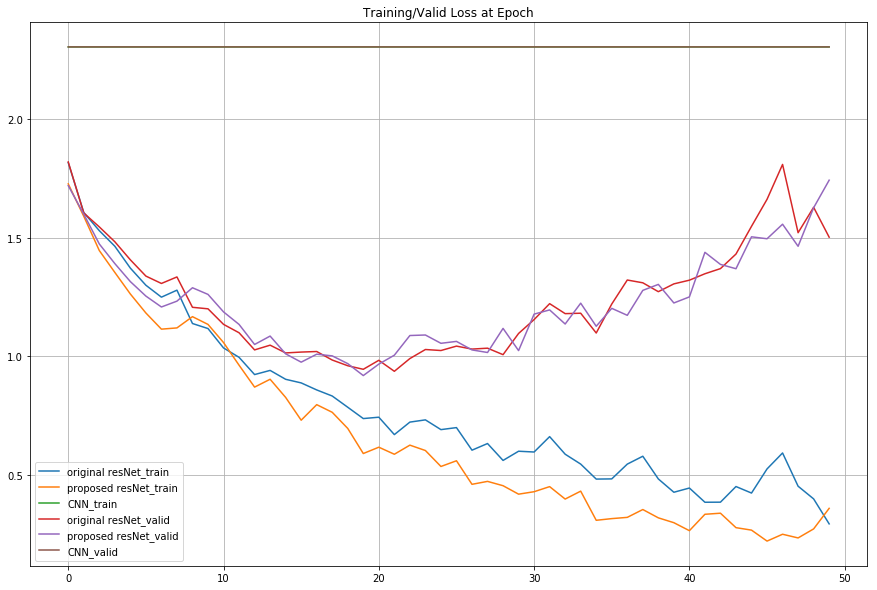

In [51]:
plot_compare_all(train_losses, valid_losses,title='Training/Valid Loss at Epoch')

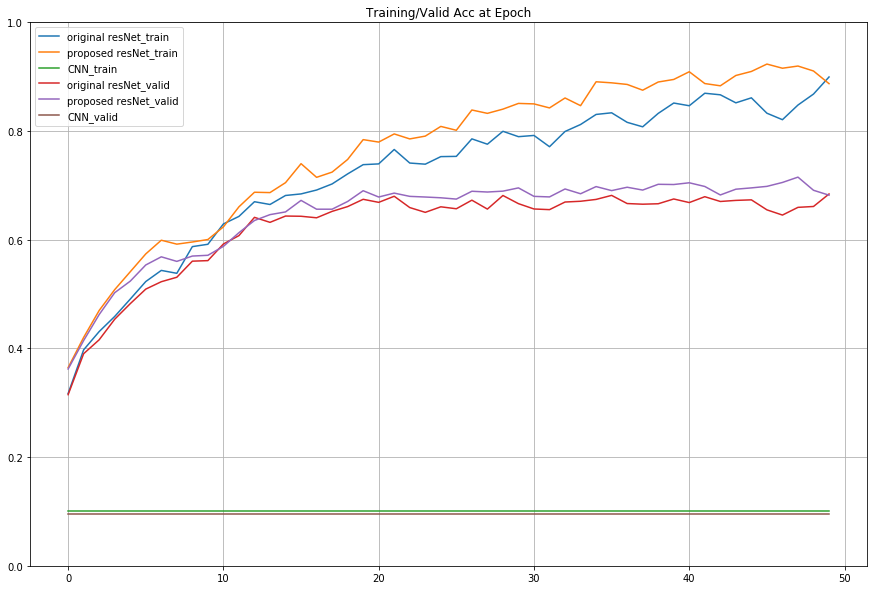

In [55]:
plot_compare_all(train_accs, valid_accs, [0, 1], title="Training/Valid Acc at Epoch")

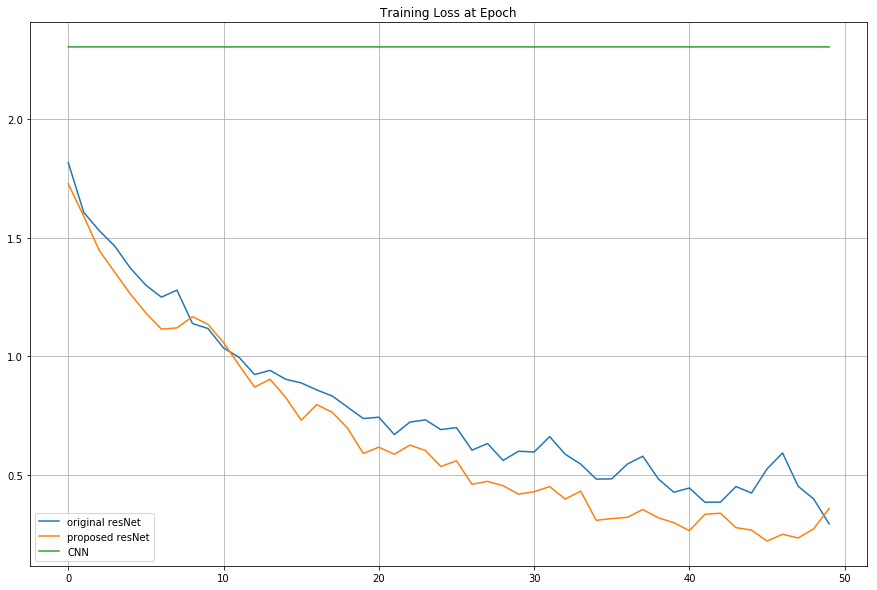

In [34]:
plot_compare(train_losses, title='Training Loss at Epoch')

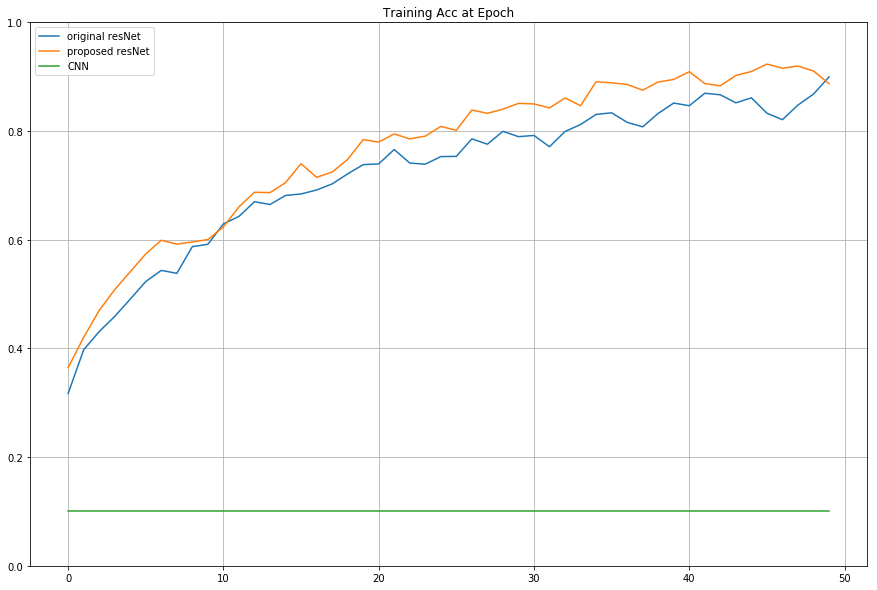

In [35]:
plot_compare(train_accs, [0, 1], title="Training Acc at Epoch")

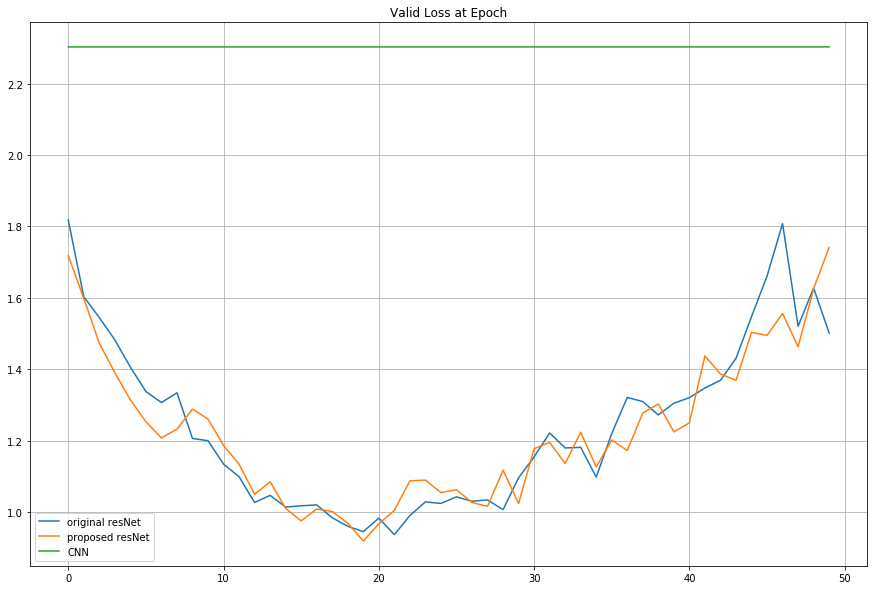

In [36]:
plot_compare(valid_losses, title='Valid Loss at Epoch')

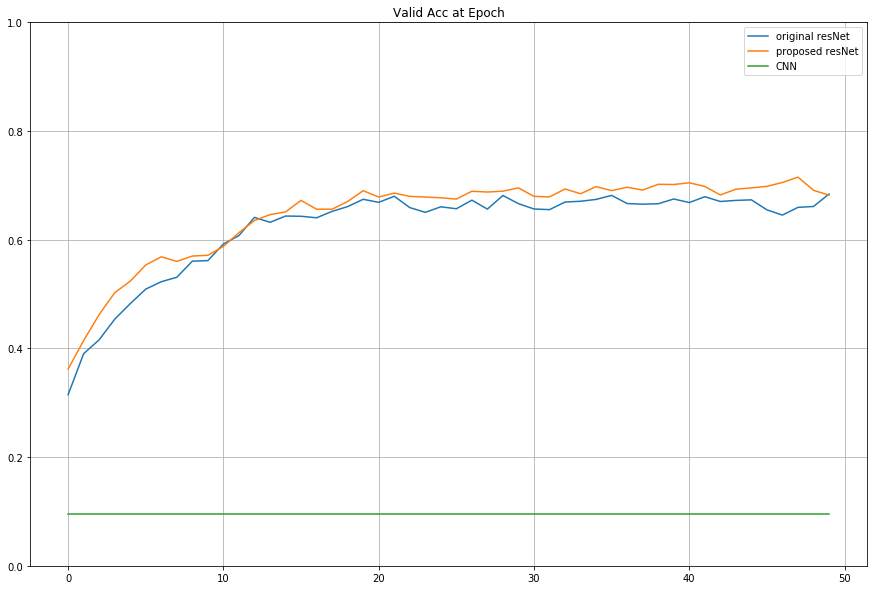

In [37]:
plot_compare(valid_accs, [0, 1.0], title="Valid Acc at Epoch")

In [39]:
print("res1 test acc : {:.2f}%".format(model1.get_accuracy(test_data, test_label)*100))
print("res2 test acc : {:.2f}%".format(model2.get_accuracy(test_data, test_label)*100))
print("conv test acc : {:.2f}%".format(model3.get_accuracy(test_data, test_label)*100))

res1 test acc : 67.59%
res2 test acc : 68.21%
conv test acc : 10.00%


In [43]:
saver = tf.train.Saver()
save_path = saver.save(sess, "resNet.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: resNet.ckpt


In [48]:
total = [train_losses, train_accs, valid_losses, valid_accs]
total_df = pd.DataFrame.from_records(total)
total_df.head()

total_df.to_csv("train_loss-train_acc-valid_loss-valid_acc.csv")

In [15]:
tf.reset_default_graph() 